## Multi-Head Attention

In [1]:
import numpy as np
import pickle

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
run_local = True # change to False if using google drive

if run_local: # place pickle file in same directory as this ipynb
    data_path = 'parsed_data_no_timestamps.pkl'
    with open(data_path, "rb") as file:
        data = pickle.load(file)
else:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/MyDrive/CS7643Group/Dataset/parsed_data_no_timestamps.pkl'
    with open(data_path, "rb") as file:
        data = pickle.load(file)

print(f"Shape of full dataset: {data.shape}")

X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print("For each input state: X position, Y position, X velocity, Y velocity, Heading")
print("For each output state: X velocity, Y velocity")

print("\nTraining Data:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print("\nValidation Data:") 
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


Shape of full dataset: (2933, 90, 5)
For each input state: X position, Y position, X velocity, Y velocity, Heading
For each output state: X velocity, Y velocity

Training Data:
X_train shape: (2346, 80, 5)
y_train shape: (2346, 10, 5)

Validation Data:
X_val shape: (587, 80, 5)
y_val shape: (587, 10, 5)


In [3]:
import torch
import torch.nn as nn

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

    def forward(self, x):
        # x: (batch_size, seq_length, embed_dim)
        attn_output, _ = self.attention(x, x, x)  # Self-attention mechanism
        return attn_output

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5, num_heads=1):
        super(TrajectoryLSTM, self).__init__()

        # Transform input size to match attention embed_dim if needed
        self.input_transform = nn.Linear(input_size, 32)  # Transform input to embed_dim
        self.dropout = nn.Dropout(dropout)  # Dropout layer

        # MultiHeadSelfAttention layer
        self.attention = MultiHeadSelfAttention(embed_dim=64, num_heads=num_heads, dropout=dropout)

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        self.layer_norm = nn.LayerNorm(hidden_size)

        # Fully connected layers for final prediction
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),  # Dropout after the first FC layer
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),  # Dropout after the second FC layer
            nn.ReLU(),
            nn.Linear(32, output_features * output_timesteps)
        )
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # Transform input to match attention's expected embed_dim
        # transformed_x = self.input_transform(x)  # Transform input to embed_dim
        # transformed_x: (batch_size, seq_length, embed_dim)

        # attn_out: (batch_size, seq_length, embed_dim)

        lstm_out, _ = self.lstm(x)  # Pass attention output to LSTM
        attn_out = self.attention(lstm_out)  # Apply attention to transformed input
        # lstm_out: (batch_size, seq_length, hidden_size)

        lstm_out = self.layer_norm(lstm_out + attn_out)  # Apply LayerNorm to LSTM output
        lstm_out = lstm_out[:, -1, :]  # Take the last time step's LSTM output
        lstm_out = self.dropout(lstm_out)  # Apply dropout to LSTM output

        out = self.fc(lstm_out)  # Fully connected layer
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, output_timesteps, output_features)


In [4]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from loss_functions import get_loss_function

# Initialize lists to store loss history
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10, loss_fn=nn.MSELoss()):
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

    best_val_loss = float('inf')
    model_save_path = "best_multihead_attention_model.pth"  # Save path for the best model

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        epoch_train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")

            optimizer.zero_grad()
            predictions = model(batch_x)
            loss = loss_fn(predictions, batch_y, batch_x[:, 0, :2])
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_train_loss += loss.item()

        scheduler.step()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
                predictions = model(batch_x)
                loss = loss_fn(predictions, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()

            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            print(f'Validation Loss: {avg_val_loss:.4f}')

            # Save the model if it has the best validation loss (Comment out if you don't want to save)
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), model_save_path)
                print(f"Saved best model with validation loss: {best_val_loss:.4f}")

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}. Model saved to {model_save_path}.")


train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
# Mess with batch size here
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


input_size = X_train.shape[2]
hidden_size = 64 # changeable
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=4).to("cuda")

loss_weights = { # Update weights of different loss terms 
    "position_loss": 1.0,
    "velocity_loss": 0.5,
    "smoothness_loss": 0.25,
    "terminal_loss": 2.0,
    "delta_loss": 0.5
}
# Customize loss function here (Everything is True/False except time_weighting_scheme)
loss_fn = get_loss_function(
    "trajectory_loss", # trajectory_loss is just position loss if everything else is False
    use_velocity_loss=True,
    use_smoothness_loss=True,
    use_terminal_loss=True,
    time_weighting_scheme='Exponential',  #None, Linear, Exponential
    use_delta_loss=True,
    prediction_horizon=10, # change to match predicted timesteps (used for time)
    loss_weights=loss_weights # defaults to ALL = 1.0 if not included
) # Add more lines as new loss functions are added

# mess with epochs, initial_lr and T_max here
train_model(model, train_loader, val_loader, num_epochs=100, initial_lr=1e-2, T_max=100, loss_fn=loss_fn)


Epoch [1/100], Training Loss: 27415.9071, LR: 0.009998
Validation Loss: 12960.0583
Saved best model with validation loss: 12960.0583
Epoch [2/100], Training Loss: 25504.8640, LR: 0.009990
Validation Loss: 13845.2213
Epoch [3/100], Training Loss: 25143.4276, LR: 0.009978
Validation Loss: 12742.9014
Saved best model with validation loss: 12742.9014
Epoch [4/100], Training Loss: 25013.3311, LR: 0.009961
Validation Loss: 12660.6508
Saved best model with validation loss: 12660.6508
Epoch [5/100], Training Loss: 25229.2810, LR: 0.009938
Validation Loss: 12512.8677
Saved best model with validation loss: 12512.8677
Epoch [6/100], Training Loss: 24827.1388, LR: 0.009911
Validation Loss: 12544.3018
Epoch [7/100], Training Loss: 24633.6036, LR: 0.009880
Validation Loss: 12576.0858
Epoch [8/100], Training Loss: 24619.7988, LR: 0.009843
Validation Loss: 12482.5475
Saved best model with validation loss: 12482.5475
Epoch [9/100], Training Loss: 24917.4578, LR: 0.009801
Validation Loss: 12552.0170
Epo

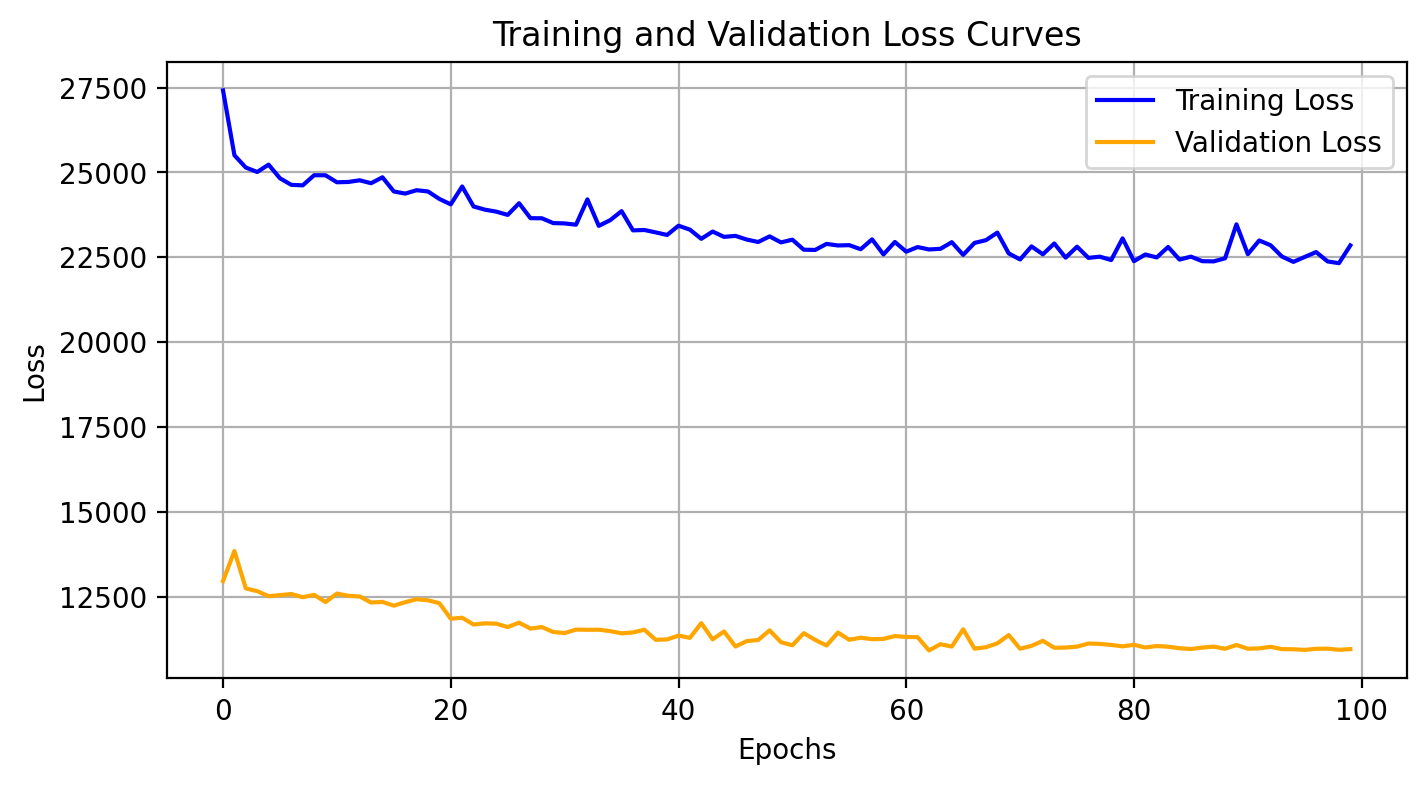

In [5]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(train_losses, val_losses)

In [6]:
from metrics import (
    compute_predicted_positions,
    compute_mean_ade,
    compute_fde,
    compute_directional_accuracy,
    compute_linear_wade,
    compute_exponential_wade
) # add new imports here as new metrics created

x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")
# Compute metrics
with torch.no_grad():
    pred_position = compute_predicted_positions(model, x, y)
    mean_ade = compute_mean_ade(pred_position, y)
    fde = compute_fde(pred_position, y)
    directional_accuracy = compute_directional_accuracy(pred_position, y)
    l_wade = compute_linear_wade(pred_position, y)
    
    alpha = 0.5 #Smaller alpha -> more uniform weights, larger alpha -> more emphasis on earlier timesteps (defaults to 0.1)
    e_wade = compute_exponential_wade(pred_position, y, alpha=alpha) 

print(f"Mean Average Displacement Error (MADE): {mean_ade:.4f}")
print(f"Final Displacement Error (FDE): {fde:.4f}")
print(f"Directional Accuracy (DA): {directional_accuracy:.4f}")
print(f"Linear Weighted Average Displacement Error (LWADE): {l_wade:.4f}")
print(f"Exponential Weighted Average Displacement Error (EWADE) with alpha={alpha}: {e_wade:.4f}")
print(f"Overall Score (Lower is better) = {e_wade + 0.5 * fde - 0.5 * directional_accuracy}")

Mean Average Displacement Error (MADE): 3.7063
Final Displacement Error (FDE): 8.1457
Directional Accuracy (DA): 0.2987
Linear Weighted Average Displacement Error (LWADE): 0.2558
Exponential Weighted Average Displacement Error (EWADE) with alpha=0.5: 0.1590
Overall Score (Lower is better) = 4.0824954360723495


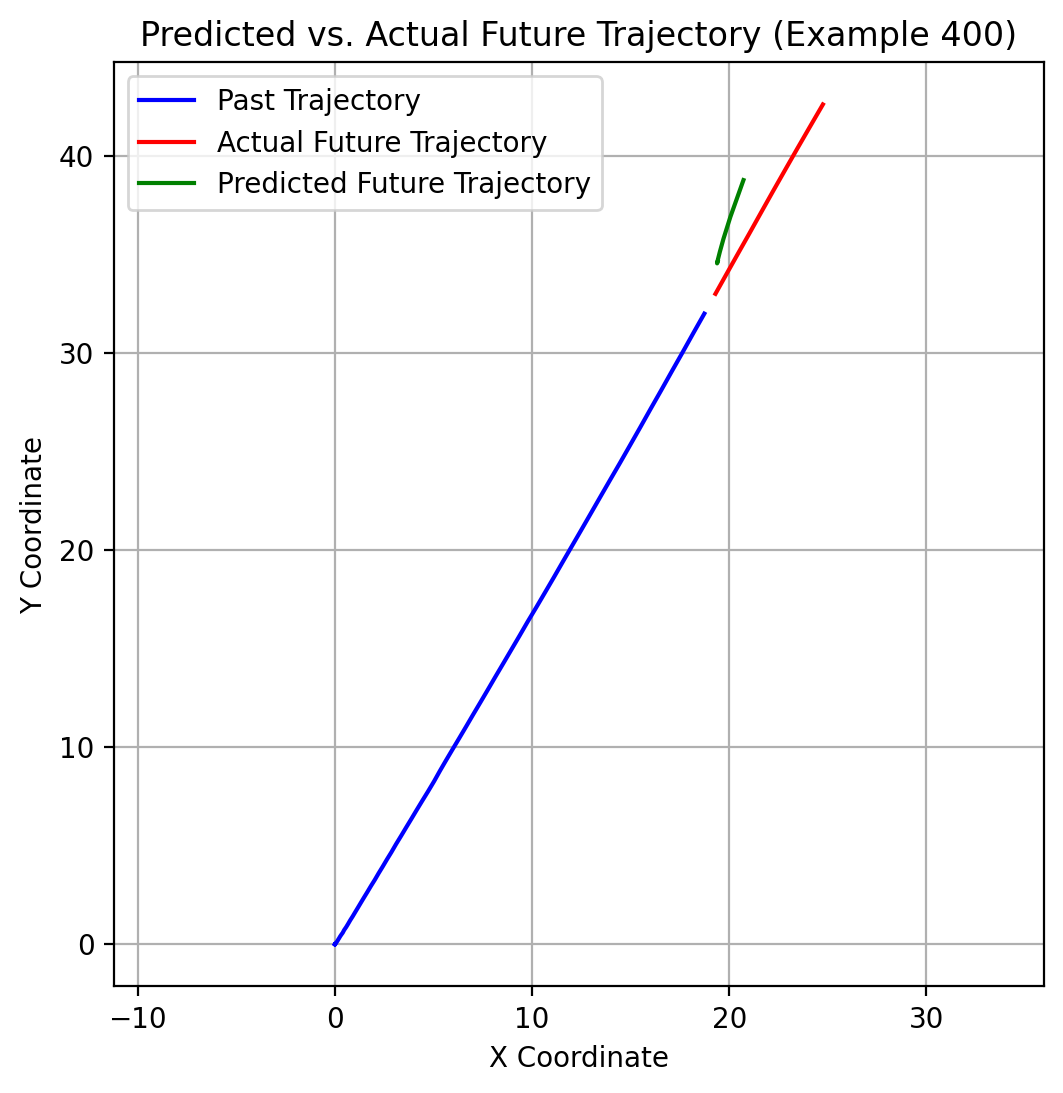

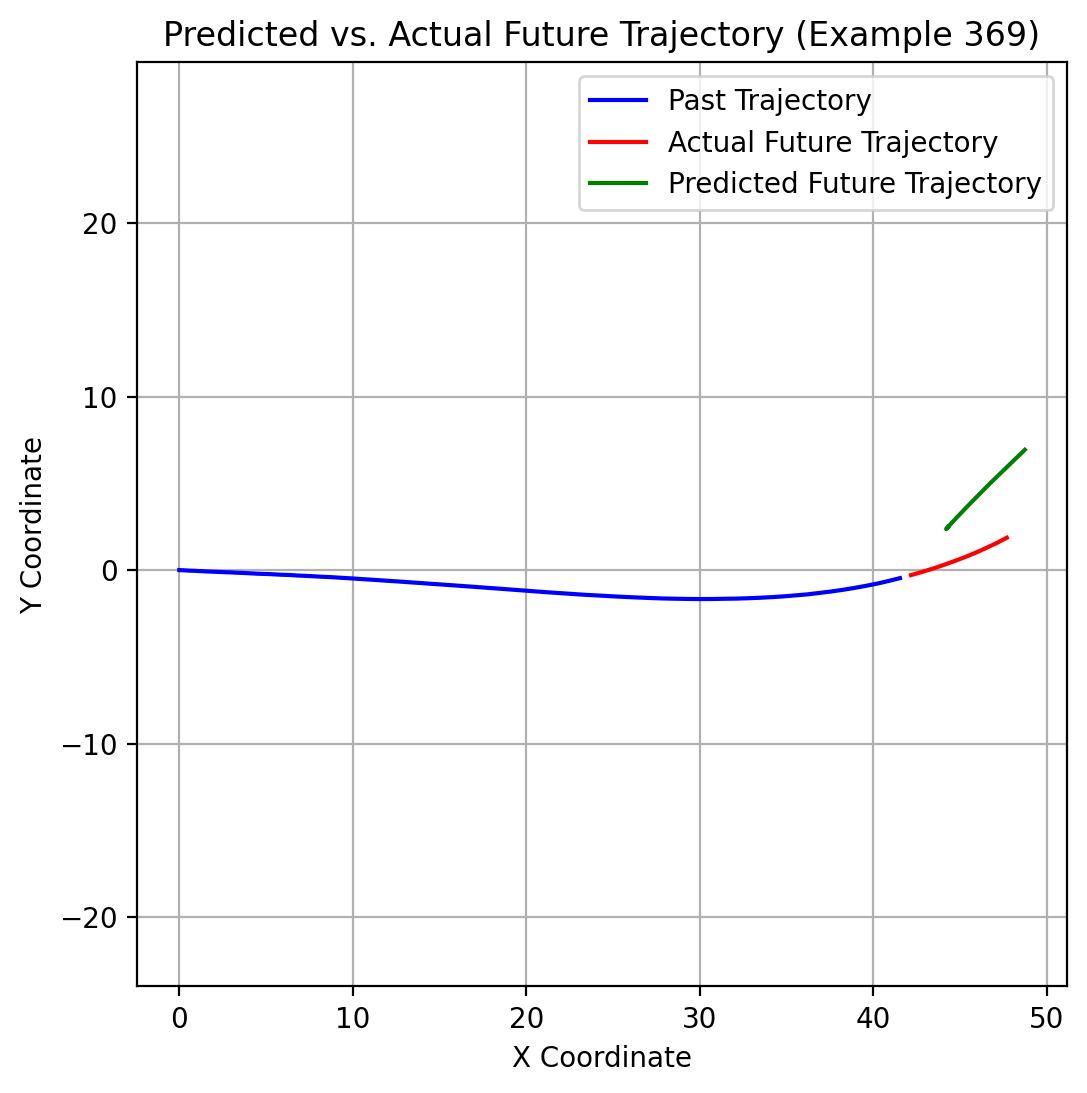

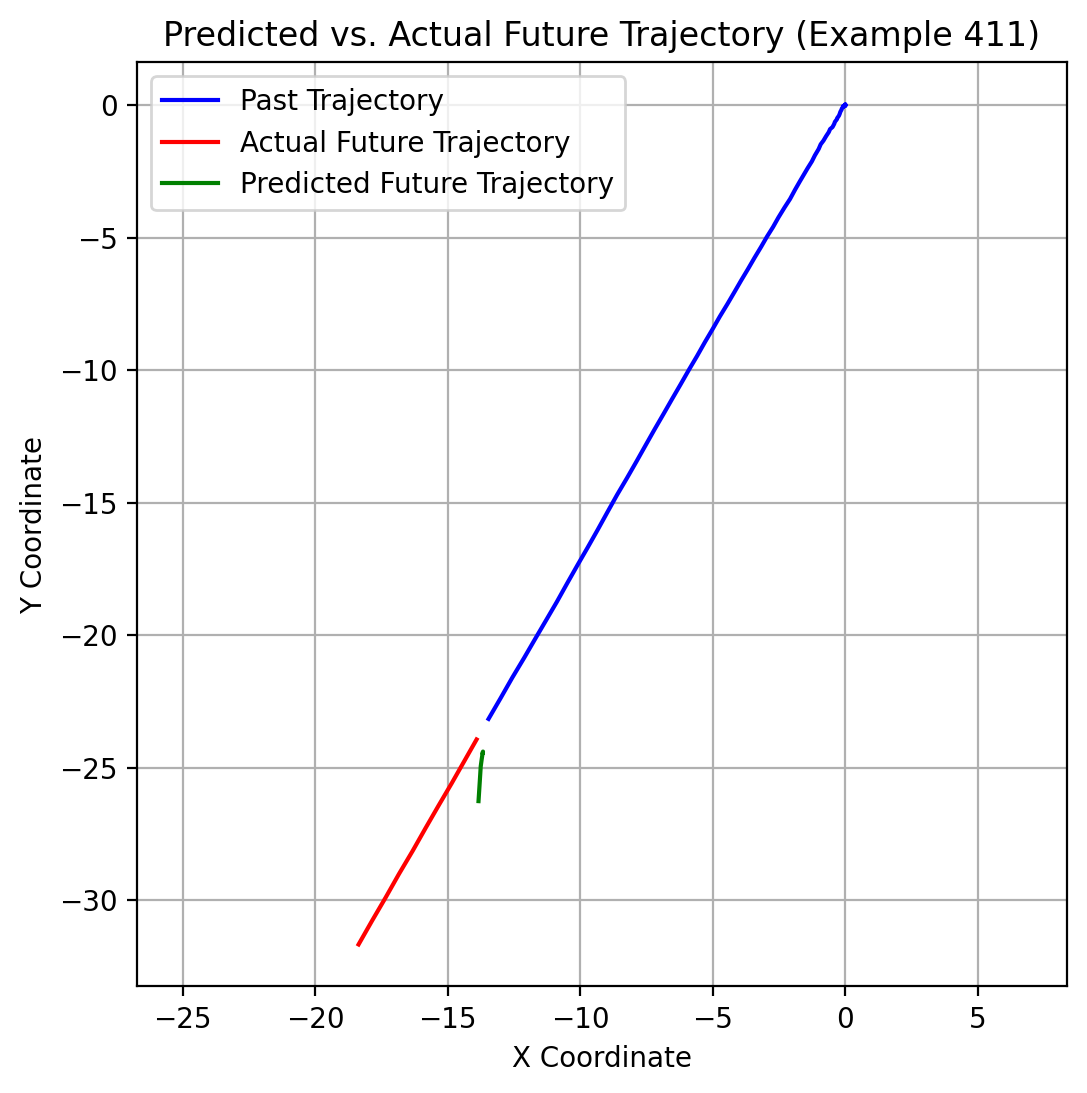

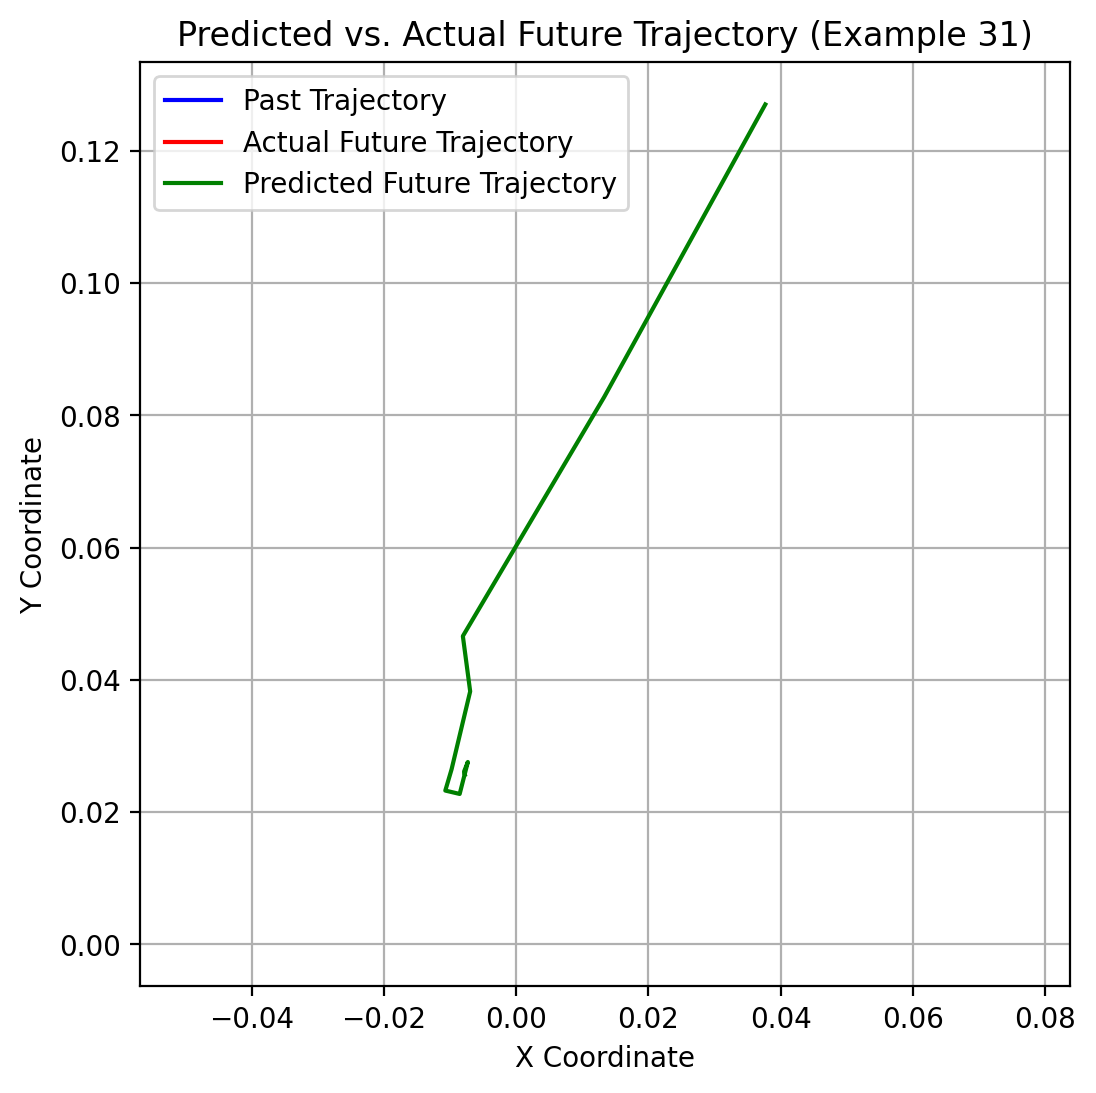

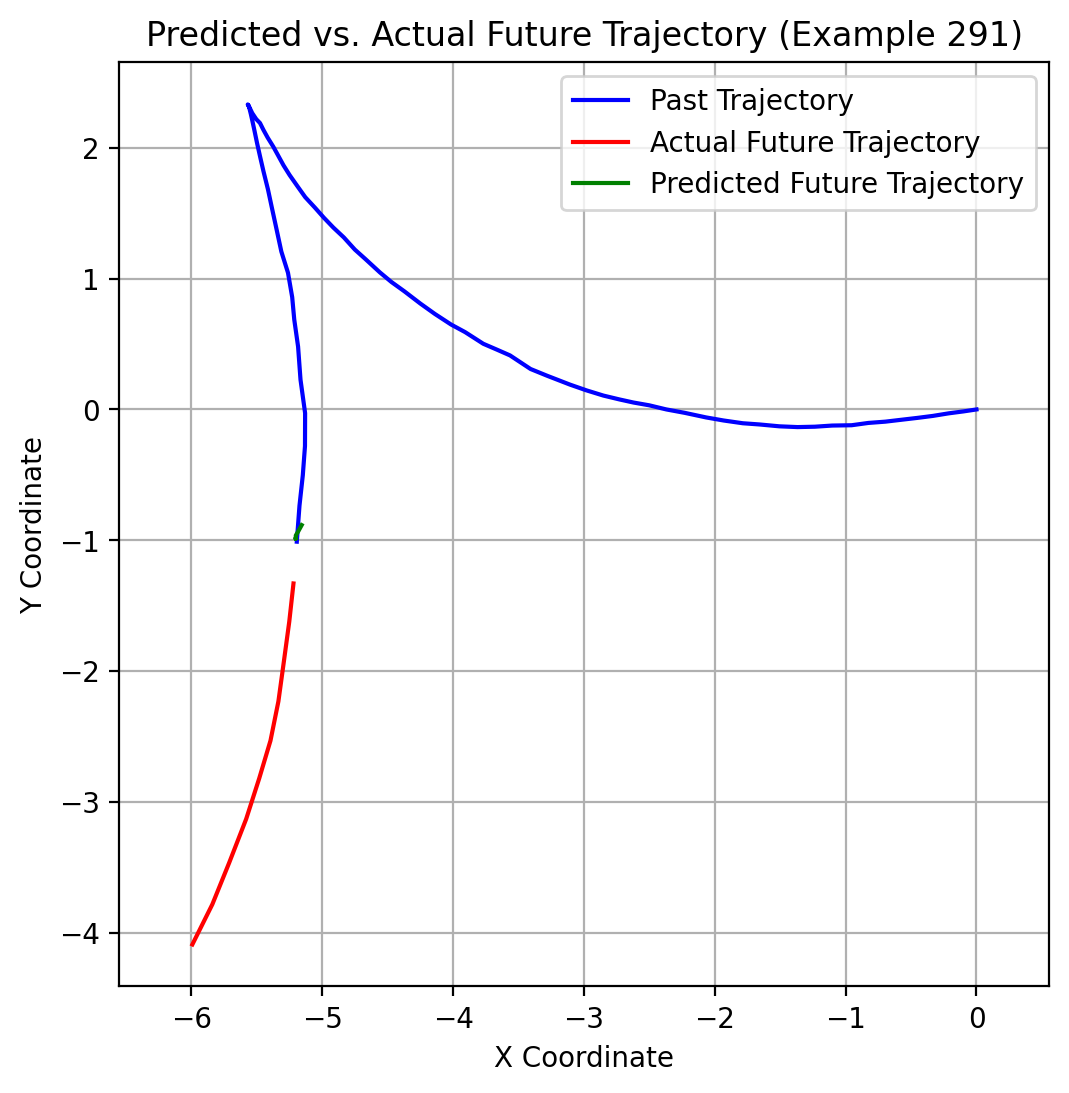

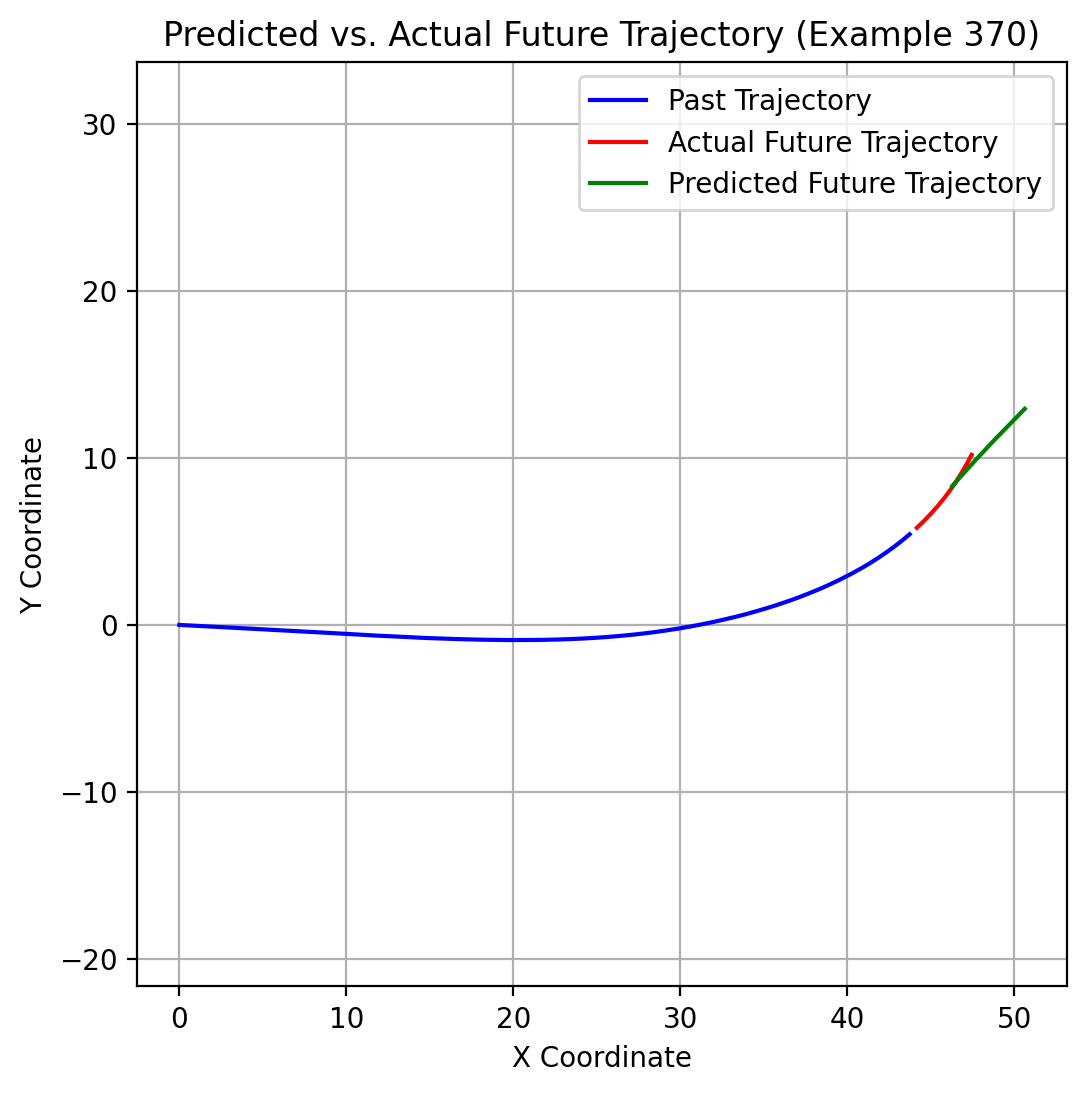

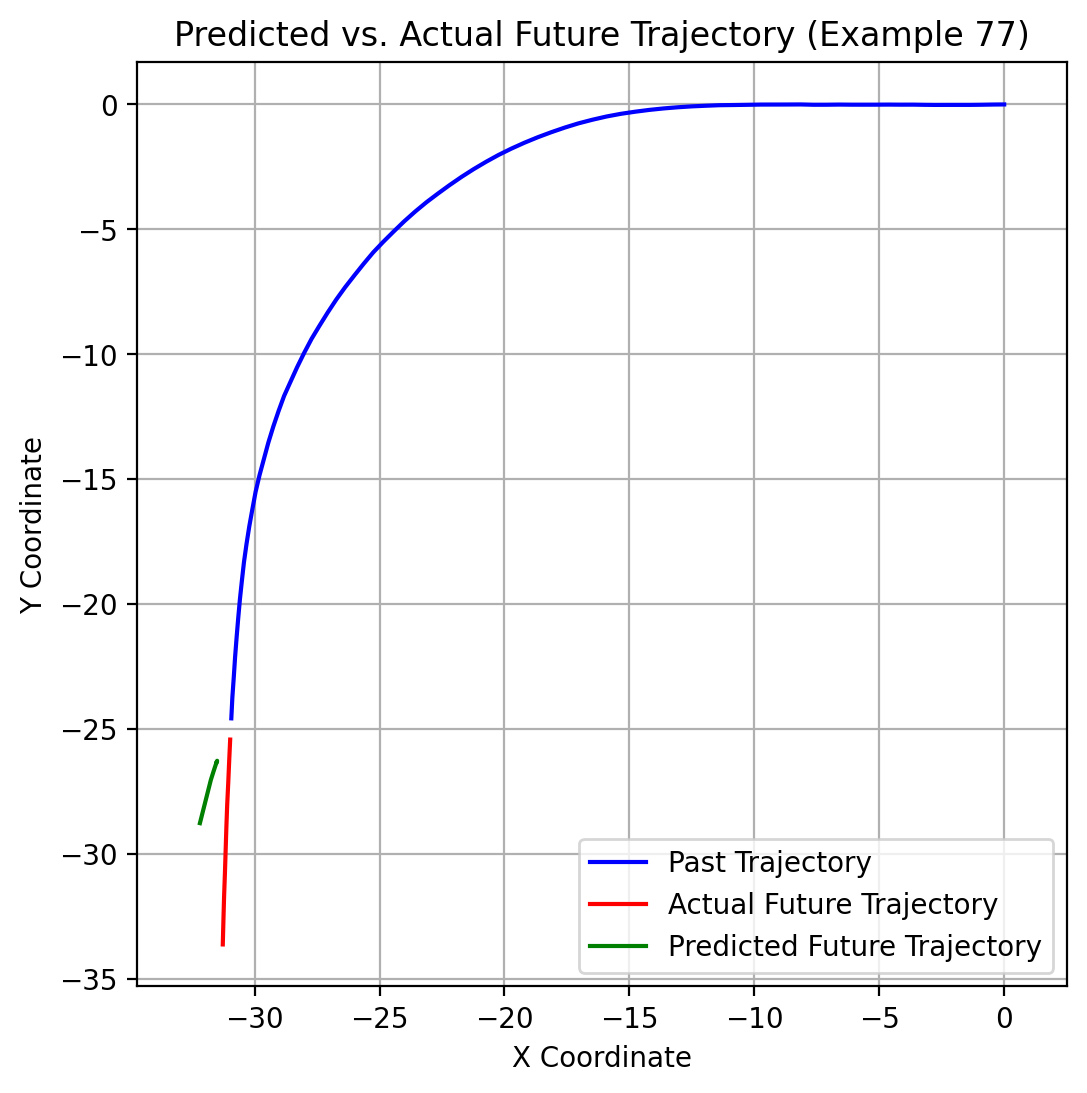

In [7]:
# Example 400 - straight path towards top right
example_index = 400
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Example 369 - very slight curve
example_index = 369
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Example 411 - straight path towards bottom left
example_index = 411
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Example 31 - No movement
example_index = 31
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Example 291 - Sharp turn
example_index = 291
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Example 370 - Smooth slight turn
example_index = 370
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Example 77 - smooth 90 degree turn
example_index = 77
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()